# Gas Storage Valuation 
These notebooks walk through the project end-to-end using the sample data.

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

BASE_DIR = Path('..').resolve()
DATA_RAW = BASE_DIR / 'data' / 'raw'
RESULTS = BASE_DIR / 'results'
RESULTS.mkdir(parents=True, exist_ok=True)
print('BASE_DIR:', BASE_DIR)

BASE_DIR: C:\Users\dappy\Downloads\Public-portfolio\Energy\gas_storage_valuation


In [5]:
import sys

# notebook add-on, to find repo root by walking up until we see src
p = Path().resolve()
while p != p.parent and not (p / "src").exists():
    p = p.parent

sys.path.insert(0, str(p))
print("Added to path:", p)


Added to path: C:\Users\dappy\Downloads\Public-portfolio\Energy\gas_storage_valuation


## 1) Load spot history + forward curve

In [6]:
spot_path = DATA_RAW / 'spot_history_ttf_like.csv'
fwd_path  = DATA_RAW / 'forward_curve_monthly.csv'

spot = pd.read_csv(spot_path, parse_dates=['date']).sort_values('date')
fwd  = pd.read_csv(fwd_path,  parse_dates=['delivery_month']).sort_values('delivery_month')

display(spot.head())
display(fwd.head())
print('Spot rows:', len(spot), 'from', spot['date'].min().date(), 'to', spot['date'].max().date())
print('Fwd months:', len(fwd), 'from', fwd['delivery_month'].min().date(), 'to', fwd['delivery_month'].max().date())

,date,spot_eur_mwh
0,2021-01-04,19.844999
1,2021-01-05,18.004999
2,2021-01-06,17.565001
3,2021-01-07,19.305000
4,2021-01-08,20.120001


,delivery_month,fwd_eur_mwh
0,2026-01-03,32.500
1,2026-01-04,31.007
2,2026-01-05,30.147
3,2026-01-06,29.747
4,2026-01-07,29.661


Spot rows: 1256 from 2021-01-04 to 2025-12-30
Fwd months: 18 from 2026-01-03 to 2027-01-08


## 2) Fit a simple mean-reverting (OU) model on log prices


In [7]:
from src.price_models import fit_ou_params, build_seasonal_theta

logp = np.log(spot["spot_eur_mwh"]).dropna()   # Series
params = fit_ou_params(logp)
params


OUParams(kappa=0.00472323537759049, theta=3.908844422179406, sigma=0.05641214942176572)

## 3) Build a seasonal long-run mean (theta)
We use monthly seasonality estimated from the historical series.

Wrote C:\Users\dappy\Downloads\Public-portfolio\Energy\gas_storage_valuation\results\Theta_History.csv


<Axes: title={'center': 'Seasonal Theta (OU mean reversion level)'}, xlabel='date'>

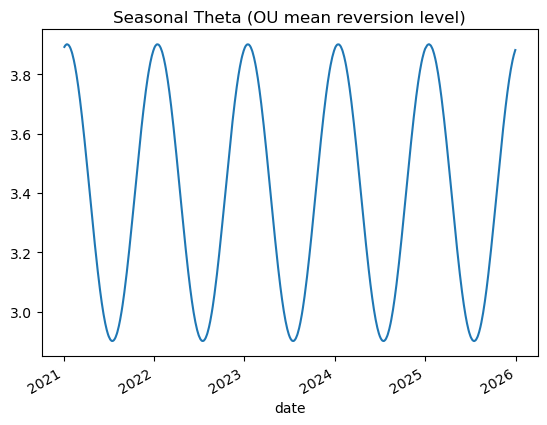

In [8]:
spot["date"] = pd.to_datetime(spot["date"])
dates = pd.DatetimeIndex(spot["date"])

theta = build_seasonal_theta(dates)
out = RESULTS / 'Theta_History.csv'
theta.to_csv(out, index=True)
print('Wrote', out)
theta.plot(title='Seasonal Theta (OU mean reversion level)')